In [1]:
import os
import shutil
import sys
import time

import numpy as np
import copy

from dolfinx import fem, mesh, plot, io, nls
from ufl import dx, ds, grad, inner, exp, sin, diff
import ufl
from mpi4py import MPI
import petsc4py

from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt


In [2]:
class Infix:

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


def logProg(sequence, every=1):

    progress = IntProgress(min=0, max=len(sequence), value=0)
    display(progress)

    for index, record in enumerate(sequence):

        if index % every == 0:
            progress.value = index
        yield record
    progress.value = len(sequence)

In [3]:
dot = Infix(inner)
teta = 0.5
dt = 5.0e-06
lam = 1.0e-02
m = 1

Domain

In [4]:
domain_mesh = mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=((0, 0), (1, 1)),
    n=(100, 100),
    cell_type=mesh.CellType.triangle
    )
base_element = ufl.FiniteElement("Lagrange", domain_mesh.ufl_cell(), 1)
space = fem.FunctionSpace(domain_mesh, base_element * base_element)

Functions

In [5]:
q, v = ufl.TestFunctions(space)

next_func = fem.Function(space)
prew_func = fem.Function(space)

c, mu = ufl.split(next_func)
c0, mu0 = ufl.split(prew_func)

next_func.x.array[:] = 0.0
# next_func.sub(0).interpolate(
#     lambda x: 0.63 + 0.02 * (0.5 - np.random.rand(x.shape[1]))
#     )
next_func.sub(0).interpolate(
    lambda x: 0.63 + 0.02 *
    (0.5 - np.where(x[0] > 0.9, np.random.rand(x.shape[1]), 0.5))
    )

next_func.x.scatter_forward()     # Don't know it

start_funcx= copy.deepcopy(next_func.x.array)

c = ufl.variable(c)
f = 100 * c**2 * (1 - c)**2
dfdc = diff(f, c)
mu_mid = (1.0-teta) * mu0 + teta*mu

F0 = (c|dot|q) * dx - (c0|dot|q) * dx + m * dt * (grad(mu_mid)|dot|grad(q)) * dx
F1 = (mu|dot|v) * dx - (dfdc|dot|v) * dx - lam * (grad(c)|dot|grad(v)) * dx
F = F0 + F1

In [6]:
# You can't set petsc options right now for nonlinaer problem
problem = fem.petsc.NonlinearProblem(F, next_func)

solver = nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6

ksp = solver.krylov_solver
opts = petsc4py.PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

In [7]:
from tqdm import tqdm
save_dir = '/home/VTK/Chan_test_Files'

In [8]:
with io.XDMFFile(
    MPI.COMM_WORLD, save_dir+'/Chan.xdmf', 'w'
    ) as file:
    file.write_mesh(domain_mesh)

    t = 0.0
    T = 10 * dt

    c_func = next_func.sub(0)
    c_space, c_points = space.sub(0).collapse()

    prew_func.x.array[:] = next_func.x.array
    time_array = np.arange(0 + dt, T, dt)
    for t in tqdm(time_array):
        r = solver.solve(next_func)
        prew_func.x.array[:] = next_func.x.array
        file.write_function(c_func, t)

100%|██████████| 9/9 [00:03<00:00,  2.30it/s]


In [15]:
norm_u_0 = c_func.x.norm()
print(f"Norm of concentrate: {norm_u_0:.2f}")

Norm of concentrate: 63.63


In [9]:
def draw_plot(space, points, func):
    c_topology, c_cell_types, c_geometry = plot.create_vtk_mesh(space)
    check = np.vstack((np.arange(len(func)), func)).T[points][:, 1]
    c_data = np.column_stack((c_geometry[:, 0:2], check))
    x_data = c_data[:, 0]
    y_data = c_data[:, 1]
    z_data = c_data[:, 2]
    plt.tripcolor(x_data, y_data, z_data, shading='gouraud')

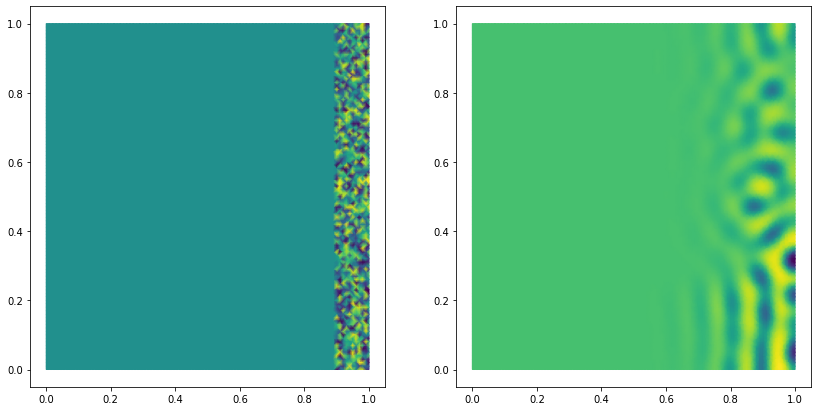

In [10]:
next_func.x.array[:]= start_funcx
check_c2 = next_func.sub(0).x.array

fig = plt.figure(figsize=(14, 7))

plt.subplot(121)
draw_plot(c_space, c_points, check_c2)
plt.subplot(122)
draw_plot(c_space, c_points, check_c1)